# The notebooks includes the process of feature selection

In [9]:
import os
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
import seaborn as sn
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [27]:
os.chdir('Q:\\5m Training Data Rasters V2\\')

Loading the data (landslide presence/absebce points)

In [28]:
data = pd.read_csv("Q:\\Training Data\\TrainingData_50%roadsremoved_2.csv")

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Landslide   1396 non-null   int64  
 1   eastness    1396 non-null   float64
 2   profile     1396 non-null   float64
 3   northernes  1396 non-null   float64
 4   spi         1396 non-null   float64
 5   tpi         1396 non-null   float64
 6   tri         1396 non-null   float64
 7   twi         1396 non-null   float64
 8   roughness   1396 non-null   float64
 9   slope       1396 non-null   float64
 10  elevation   1396 non-null   float64
 11  d_river     1396 non-null   float64
 12  landforms   1396 non-null   int64  
 13  d_roads     1396 non-null   float64
 14  losmasse    1396 non-null   int64  
 15  forestloss  1396 non-null   int64  
 16  ndvi        1396 non-null   float64
 17  a_temp      1396 non-null   float64
 18  a_perc      1396 non-null   float64
 19  landuse     1396 non-null  

In [30]:
data= data.drop(columns=['geometry'])
data.head()

,Landslide,eastness,profile,northernes,spi,tpi,tri,twi,roughness,slope,...,d_river,landforms,d_roads,losmasse,forestloss,ndvi,a_temp,a_perc,landuse,soil_con
0,0,0.501105,-11.345300,-0.865386,-1.249440,0.084423,0.924816,7.47701,0.956711,4.033360,...,148.6230,5,517.814,130,0,0.254263,7.89671,1904.09,5,3
1,0,0.303129,0.804059,0.952949,-3.083090,0.001396,0.030275,11.97080,0.030994,0.132424,...,128.7100,5,169.992,130,0,0.343899,7.55125,2037.47,10,7
2,0,-0.978111,-11.616400,-0.208084,2.620640,-0.001568,2.470670,9.08558,2.414500,11.095500,...,121.9150,6,310.503,130,0,0.303695,7.63726,2008.17,2,3
3,0,0.793612,-4.607510,-0.608424,-1.933110,0.039263,0.580487,7.65612,0.625927,2.759280,...,81.4413,5,513.673,130,0,0.352407,7.72843,1994.25,10,7
4,0,-0.353161,-25.208400,-0.935562,0.196974,0.151871,4.946400,5.50977,5.028590,22.239100,...,627.6550,6,136.261,130,0,0.252834,7.52262,2085.11,5,2


Plotting the correlation matrix to check the linear relation between our predictors

In [31]:
df = data.iloc[:, 1:] # Remove the variable representing landslide/non-landslide (in my case the first column)

#dropping categorical variables
df= df.drop(columns=['landforms', 'losmasse', 'forestloss','landuse','soil_con'])

df.replace(-9999, pd.NA, inplace=True)
df.dropna(inplace=True)

for column in df:
    # If the column is of object type, convert it to float64
    if df[column].dtype == 'object':
        df[column] = df[column].astype('float64')
df.head()

#generating correlation matrix
corr = df.corr(method='pearson')

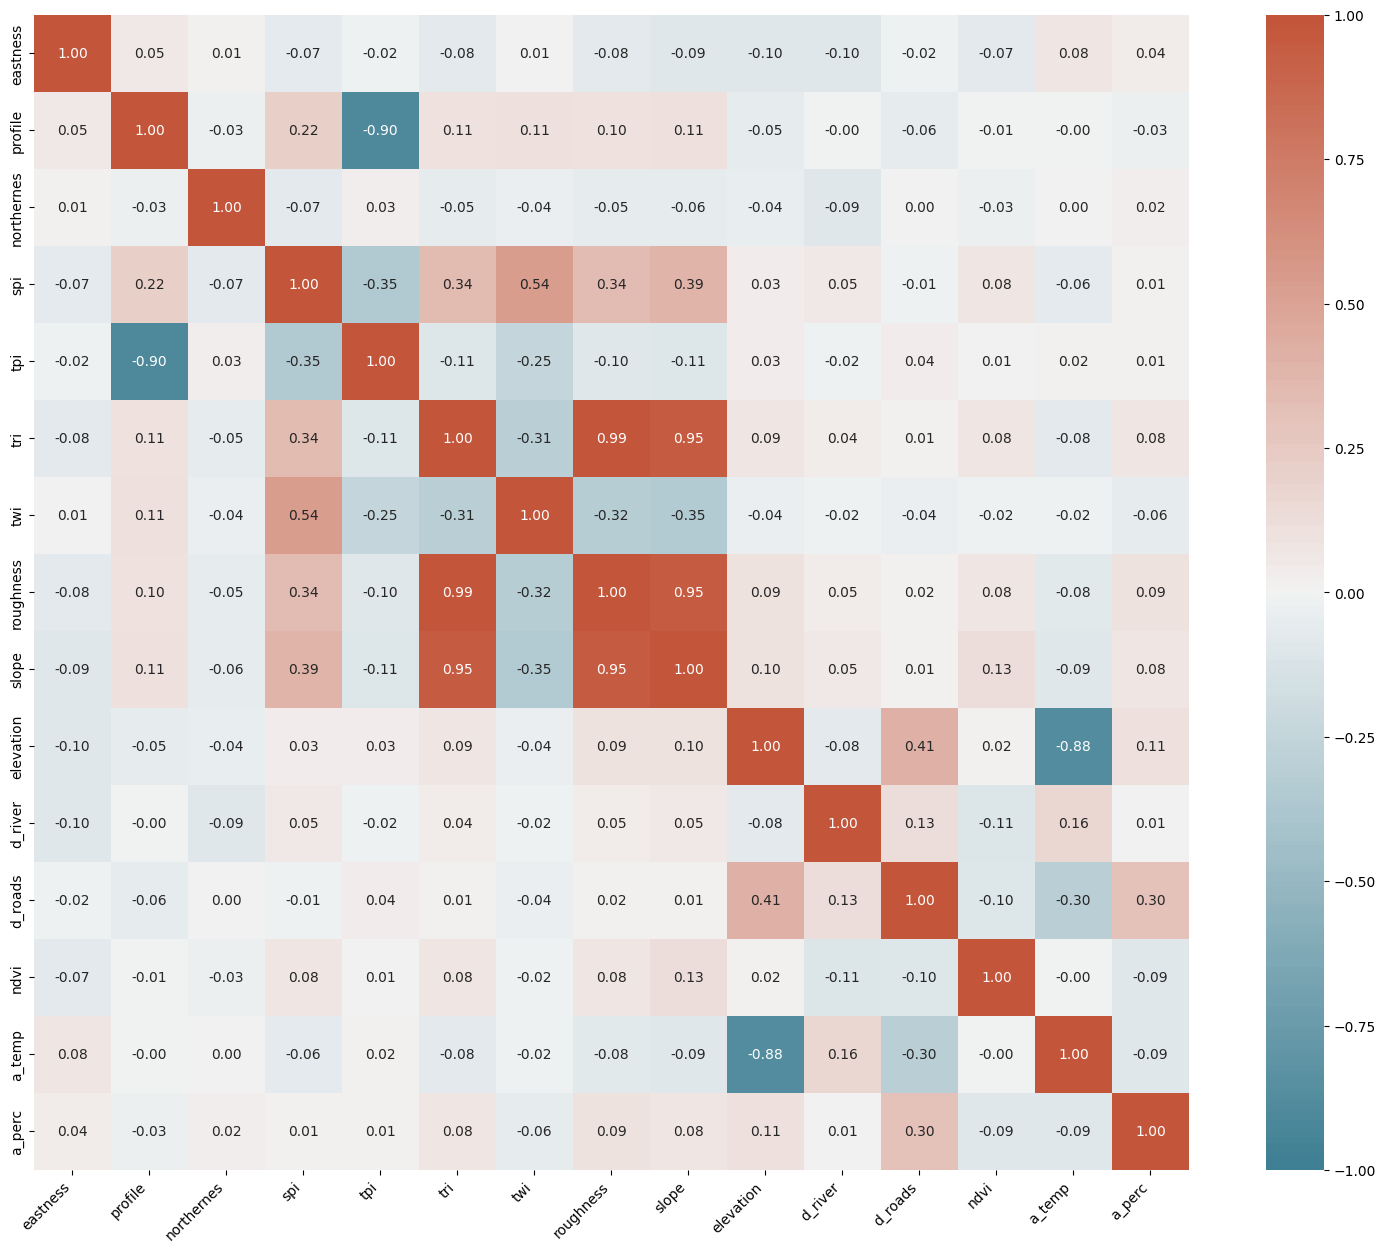

In [32]:
 # Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

ax = sn.heatmap(
    corr, 
    annot=True,
    fmt='.2f',
    vmin=-1, vmax=1, center=0,
    cmap=sn.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.savefig('E:\\Plots\\correlation_50%roadsremoved_2.png', bbox_inches='tight', dpi=600)
plt.show()

There are several variables that are highly correlated. We want to remove variables that have strong negative and positive correlation 

In [33]:
correlation_threshold = 0.75

def correlated_feature_pairs(dataset, threshold):
    correlated_pairs = []
    corr_matrix = dataset.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]
                correlated_pairs.append((feature1, feature2))
    return correlated_pairs

correlated_pairs = correlated_feature_pairs(df, correlation_threshold)

print(f"Total, {len(correlated_pairs)}, correlated pairs found.")
print("")

for pair in correlated_pairs:
    print(f"Correlated Pairs: {pair[0]} and {pair[1]}")

Total, 5, correlated pairs found.

Correlated Pairs: tpi and profile
Correlated Pairs: roughness and tri
Correlated Pairs: slope and tri
Correlated Pairs: slope and roughness
Correlated Pairs: a_temp and elevation


Some variables correlate with multiple other variables. We only want to select a set of correlated variables

In [34]:
def correlation_detection(dataset, threshold):
    col_corr = set()
    correlated_pairs = []
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [35]:
correlated_features = correlation_detection(df, 0.75) # apply the function to find correlated variables
len(set(correlated_features))

4

In [36]:
correlated_features

{'a_temp', 'roughness', 'slope', 'tpi'}

Drop highly correlated predictors

In [37]:
data_selected = data.drop(columns=correlated_features)

In [38]:
data_selected.head()

,Landslide,eastness,profile,northernes,spi,tri,twi,elevation,d_river,landforms,d_roads,losmasse,forestloss,ndvi,a_perc,landuse,soil_con
0,0,0.501105,-11.345300,-0.865386,-1.249440,0.924816,7.47701,37.6218,148.6230,5,517.814,130,0,0.254263,1904.09,5,3
1,0,0.303129,0.804059,0.952949,-3.083090,0.030275,11.97080,38.8094,128.7100,5,169.992,130,0,0.343899,2037.47,10,7
2,0,-0.978111,-11.616400,-0.208084,2.620640,2.470670,9.08558,56.4684,121.9150,6,310.503,130,0,0.303695,2008.17,2,3
3,0,0.793612,-4.607510,-0.608424,-1.933110,0.580487,7.65612,31.5688,81.4413,5,513.673,130,0,0.352407,1994.25,10,7
4,0,-0.353161,-25.208400,-0.935562,0.196974,4.946400,5.50977,33.6191,627.6550,6,136.261,130,0,0.252834,2085.11,5,2


In [39]:
data_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Landslide   1396 non-null   int64  
 1   eastness    1396 non-null   float64
 2   profile     1396 non-null   float64
 3   northernes  1396 non-null   float64
 4   spi         1396 non-null   float64
 5   tri         1396 non-null   float64
 6   twi         1396 non-null   float64
 7   elevation   1396 non-null   float64
 8   d_river     1396 non-null   float64
 9   landforms   1396 non-null   int64  
 10  d_roads     1396 non-null   float64
 11  losmasse    1396 non-null   int64  
 12  forestloss  1396 non-null   int64  
 13  ndvi        1396 non-null   float64
 14  a_perc      1396 non-null   float64
 15  landuse     1396 non-null   int64  
 16  soil_con    1396 non-null   int64  
dtypes: float64(11), int64(6)
memory usage: 185.5 KB


Plotting a new correlation matrix without highly correlated features

In [40]:
def correlation_matrix(df):
    corr = df.corr(method='pearson')
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sn.diverging_palette(230, 20, as_cmap=True)

    sn.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

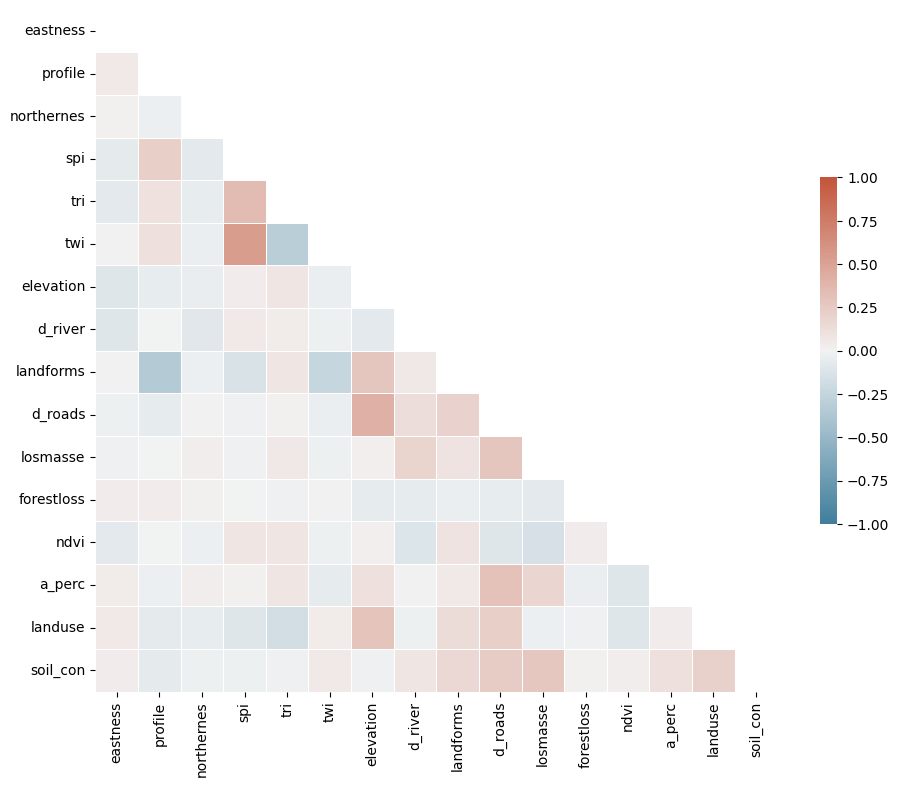

In [41]:
correlation_matrix(data_selected.iloc[:, 1:])

Plotting the distributions of the selected features

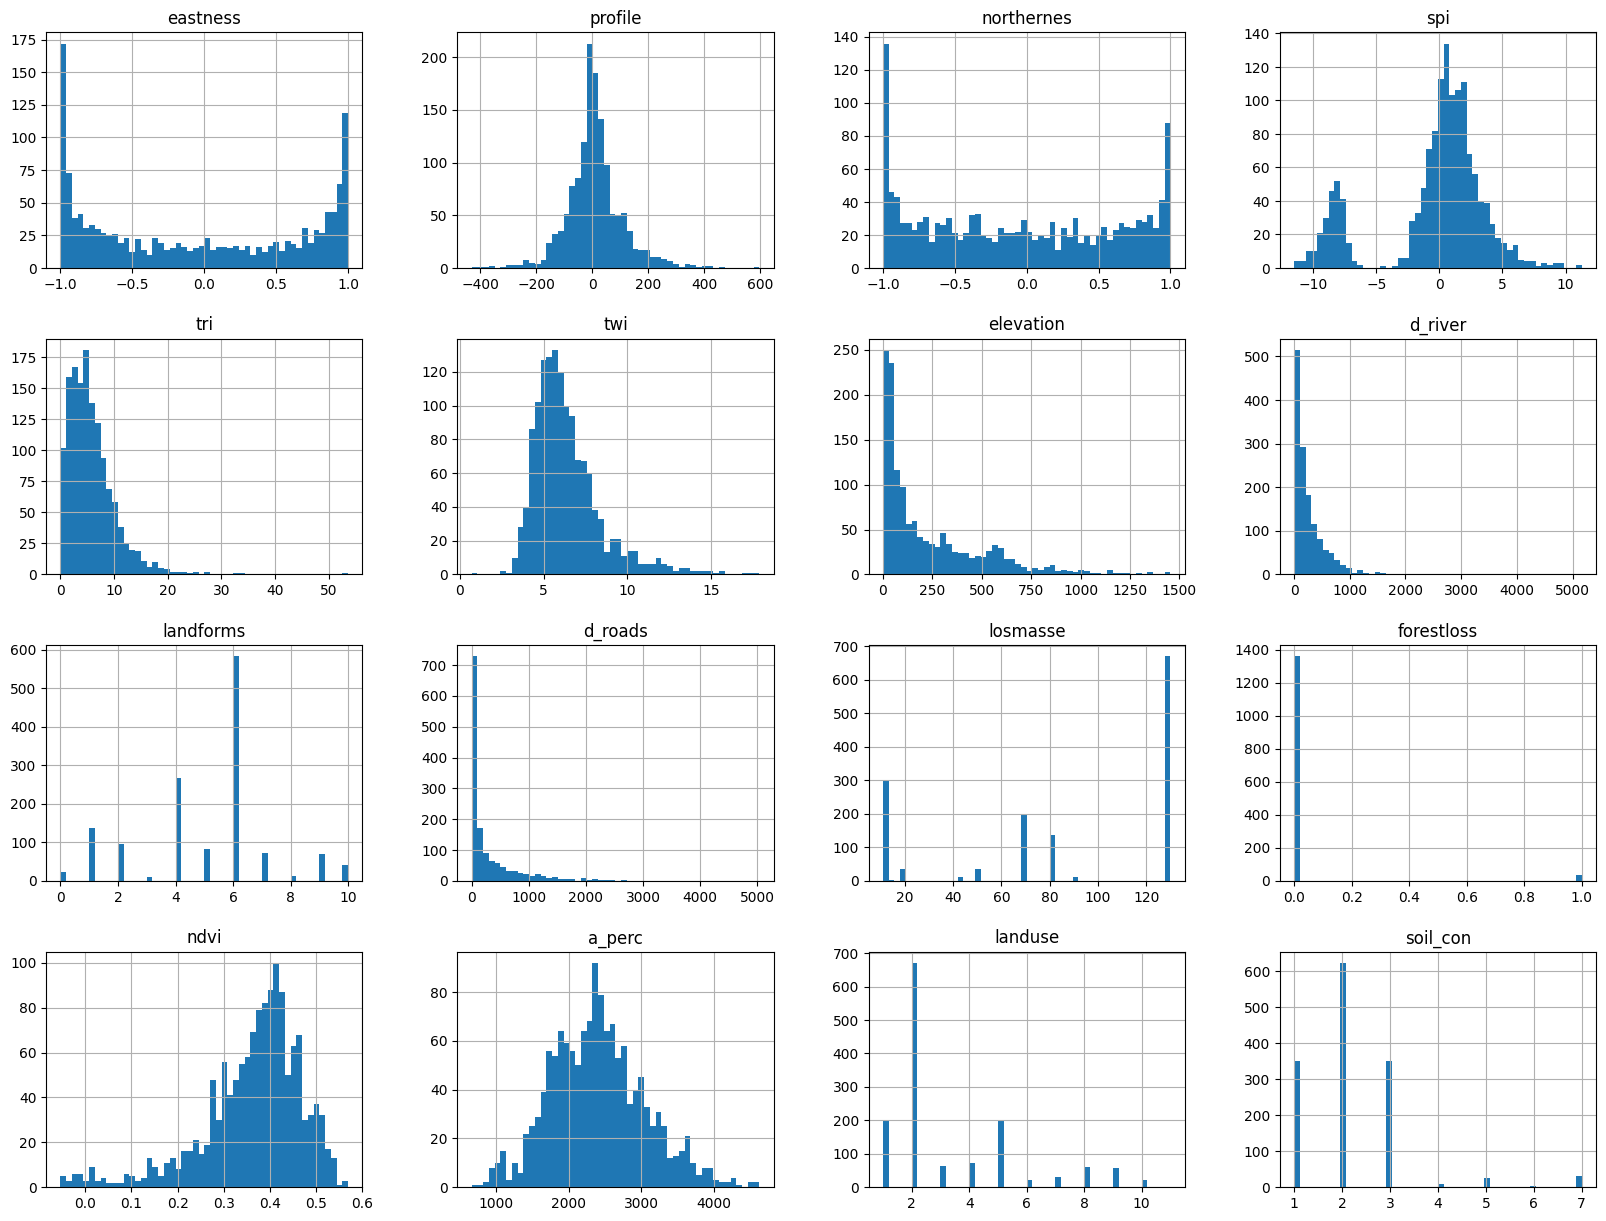

In [42]:
data_selected.iloc[:, 1:].hist(bins=50, figsize=(20,15))
plt.show()

# Feature Selection using Random Forest

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [44]:
X = data_selected.iloc[:, 1:]

In [48]:
X[:8]

,eastness,profile,northernes,spi,tri,twi,elevation,d_river,landforms,d_roads,losmasse,forestloss,ndvi,a_perc,landuse,soil_con
0,0.501105,-11.345300,-0.865386,-1.249440,0.924816,7.47701,37.62180,148.6230,5,517.814,130,0,0.254263,1904.09,5,3
1,0.303129,0.804059,0.952949,-3.083090,0.030275,11.97080,38.80940,128.7100,5,169.992,130,0,0.343899,2037.47,10,7
2,-0.978111,-11.616400,-0.208084,2.620640,2.470670,9.08558,56.46840,121.9150,6,310.503,130,0,0.303695,2008.17,2,3
3,0.793612,-4.607510,-0.608424,-1.933110,0.580487,7.65612,31.56880,81.4413,5,513.673,130,0,0.352407,1994.25,10,7
4,-0.353161,-25.208400,-0.935562,0.196974,4.946400,5.50977,33.61910,627.6550,6,136.261,130,0,0.252834,2085.11,5,2
5,0.659699,52.139400,-0.751530,-8.738770,2.150390,5.05568,54.28020,91.7424,6,882.040,130,0,0.270033,1982.22,5,3
6,0.723237,3.988870,-0.690600,-2.848010,0.149414,9.54914,33.06100,56.8335,5,514.742,130,0,0.307945,1988.43,10,7
7,-0.421061,4.789320,-0.907032,1.094900,0.354868,11.41490,9.06038,39.6385,5,161.838,42,1,0.410607,1899.29,3,2


In [49]:
y = data_selected["Landslide"]

In [50]:
y[:8]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
Name: Landslide, dtype: int64

Splitting our data into a training and a testing set, 70% and 30% respectivly.Splitting is stratified after classes, so that we get the same amount of landslide and non-landslide samples in both sets

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [52]:
classifier = RandomForestClassifier(random_state=42)

In [53]:
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

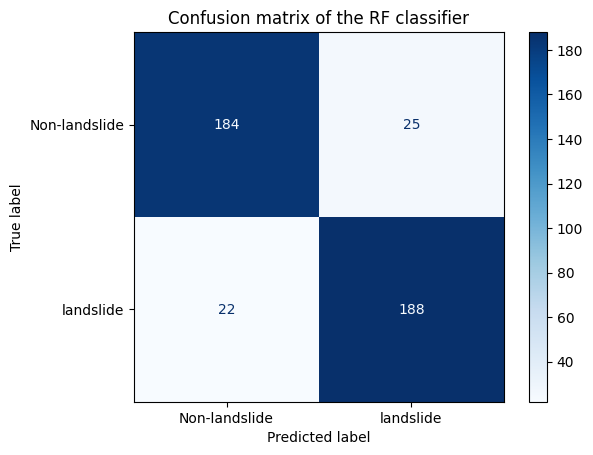

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        cmap="Blues", 
                                        display_labels=["Non-landslide", "landslide"])

plt.title('Confusion matrix of the RF classifier')
plt.show()

Plotting the feature importance graph

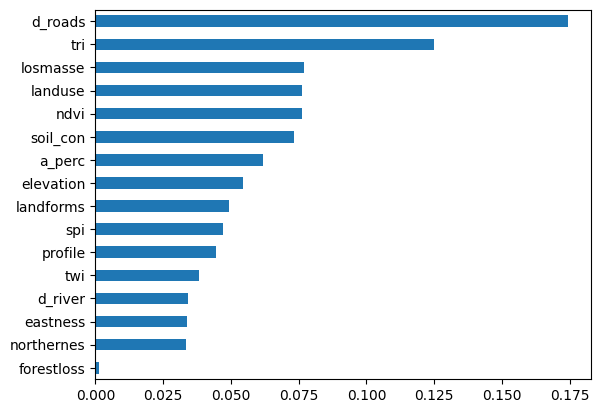

In [57]:
feat_importances = pd.Series(classifier.feature_importances_, index=X.columns)
feat_importances.nsmallest(25).plot(kind='barh')
plt.savefig('E:\\Plots\\feature_importance_50%roadsremoved_2.png', bbox_inches='tight', dpi=600)

The variable "forestloss" have very little significance for the model and is therefore dropped

The variables dropped because they are highly correlated or have extremely low significance for the model is: annual temperature, roughness, slope, tpi and forest loss

In [58]:
data_selected = data.drop(columns=['a_temp', 'roughness', 'slope', 'tpi','forestloss'])

In [59]:
data_selected.head()

,Landslide,eastness,profile,northernes,spi,tri,twi,elevation,d_river,landforms,d_roads,losmasse,ndvi,a_perc,landuse,soil_con
0,0,0.501105,-11.345300,-0.865386,-1.249440,0.924816,7.47701,37.6218,148.6230,5,517.814,130,0.254263,1904.09,5,3
1,0,0.303129,0.804059,0.952949,-3.083090,0.030275,11.97080,38.8094,128.7100,5,169.992,130,0.343899,2037.47,10,7
2,0,-0.978111,-11.616400,-0.208084,2.620640,2.470670,9.08558,56.4684,121.9150,6,310.503,130,0.303695,2008.17,2,3
3,0,0.793612,-4.607510,-0.608424,-1.933110,0.580487,7.65612,31.5688,81.4413,5,513.673,130,0.352407,1994.25,10,7
4,0,-0.353161,-25.208400,-0.935562,0.196974,4.946400,5.50977,33.6191,627.6550,6,136.261,130,0.252834,2085.11,5,2


In [60]:
data_selected.to_csv('Q:\\Training Data\\TrainingData_50%roadsremoved_2_RF_FS.csv', index = False)